In [1]:
import pandas as pd
import xlrd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind



In [2]:
missing_values = ["n/a", "na", "--"]
purchaseBehvaiour=pd.read_csv("files/QVI_purchase_behaviour.csv",na_values = missing_values)

In [3]:
transactionData=pd.read_excel("files/QVI_transaction_data.xlsx",na_values = missing_values)


In [4]:
#purchaseBehvaiour.head()

In [5]:
transactionData.head()
purchaseBehvaiour.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [6]:
#Turn date into date format from integer format
transactionData["DATE"] = pd.to_datetime(transactionData["DATE"], origin ='1899/12/30', unit = 'D')

In [7]:
#quick summary of the prod_name column
transactionData['PROD_NAME'].describe()

count                                     264836
unique                                       114
top       Kettle Mozzarella   Basil & Pesto 175g
freq                                        3304
Name: PROD_NAME, dtype: object

In [8]:
#we will look at the prod sizes, and prod brands later so I am multiplying the PROD_NAME column and calling it PROD_SIZES and PROD_BRAND for later analysis.
transactionData['PROD_SIZES']=transactionData['PROD_NAME']
transactionData['PROD_BRAND']=transactionData['PROD_NAME']

In [9]:
#remove special characters 
transactionData['PROD_NAME']=transactionData['PROD_NAME'].str.replace('\W', ' ', regex=True)
#remove numbers
transactionData['PROD_NAME']=transactionData['PROD_NAME'].str.replace('\d+', ' ',regex=True)
transactionData['PROD_NAME']=transactionData['PROD_NAME'].str.replace('g', ' ',regex=True)
transactionData['PROD_NAME']=transactionData['PROD_NAME'].str.replace('\s+', ' ',regex=True)

In [10]:
transactionData['PROD_NAME'].head()

0            Natural Chip Compny SeaSalt 
1                       CCs Nacho Cheese 
2       Smiths Crinkle Cut Chips Chicken 
3       Smiths Chip Thinly S Cream Onion 
4    Kettle Tortilla ChpsHny Jlpno Chili 
Name: PROD_NAME, dtype: object

In [11]:
#let's create a list with the product names
prod_name_list=[]
for x in transactionData.index:
    b=transactionData.PROD_NAME[x]
    prod_name_list.append(b)
print(prod_name_list[0:26])
#we can see that there are some salsa products that we dont want

['Natural Chip Compny SeaSalt ', 'CCs Nacho Cheese ', 'Smiths Crinkle Cut Chips Chicken ', 'Smiths Chip Thinly S Cream Onion ', 'Kettle Tortilla ChpsHny Jlpno Chili ', 'Old El Paso Salsa Dip Tomato Mild ', 'Smiths Crinkle Chips Salt Vine ar ', 'Grain Waves Sweet Chilli ', 'Doritos Corn Chip Mexican Jalapeno ', 'Grain Waves Sour Cream Chives G', 'Smiths Crinkle Chips Salt Vine ar ', 'Kettle Sensations Siracha Lime ', 'Twisties Cheese ', 'WW Crinkle Cut Chicken ', 'Thins Chips Li ht Tan y ', 'CCs Ori inal ', 'Bur er Rin s ', 'NCC Sour Cream Garden Chives ', 'Doritos Corn Chip Southern Chicken ', 'Cheezels Cheese Box ', 'Smiths Crinkle Ori inal ', 'NCC Sour Cream Garden Chives ', 'Infzns Crn Crnchers Tan y Gcamole ', 'Kettle Sea Salt And Vine ar ', 'Kettle Tortilla ChpsHny Jlpno Chili ', 'Old El Paso Salsa Dip Tomato Mild ']


#let's see the words
new_list=[]
for word in prod_name_list:
    new_list.append(word.split(' '))
#print(new_list[0:5])
#let's see all the unique words that have been used
res = list(set(i for j in new_list for i in j))
print(res)
#we can see that there are some words that have no meaning

In [12]:
#let's remove the rows that contain salsa products from the data set
transactionData = transactionData[transactionData["PROD_NAME"].str.contains("Salsa") == False]


In [13]:
#let's see if there are any missing values
print(transactionData.isnull().values.any())
#we can see that there are no missing values

False


In [14]:
#let's check the summary statistics of the dataframe to see if there are any outliers
print(transactionData.describe())

           STORE_NBR  LYLTY_CARD_NBR        TXN_ID       PROD_NBR  \
count  246742.000000    2.467420e+05  2.467420e+05  246742.000000   
mean      135.051098    1.355310e+05  1.351311e+05      56.351789   
std        76.787096    8.071528e+04  7.814772e+04      33.695428   
min         1.000000    1.000000e+03  1.000000e+00       1.000000   
25%        70.000000    7.001500e+04  6.756925e+04      26.000000   
50%       130.000000    1.303670e+05  1.351830e+05      53.000000   
75%       203.000000    2.030840e+05  2.026538e+05      87.000000   
max       272.000000    2.373711e+06  2.415841e+06     114.000000   

            PROD_QTY      TOT_SALES  
count  246742.000000  246742.000000  
mean        1.908062       7.321322  
std         0.659831       3.077828  
min         1.000000       1.700000  
25%         2.000000       5.800000  
50%         2.000000       7.400000  
75%         2.000000       8.800000  
max       200.000000     650.000000  


we can see that the mean product quantity is 1.9 however maximum product quantity is 200. Could that be a mistake? Let's check the transaction, to see.

/Users/nisanbaysal/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='PROD_QTY'>

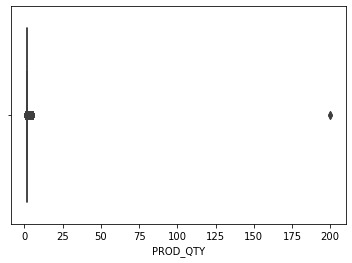

In [15]:
#Let's check if there are other outliers
sns.boxplot(transactionData['PROD_QTY'])

In [16]:
#Let's select the outlier rows
check_outlier = transactionData[transactionData['PROD_QTY'] >150] 
print(check_outlier)

            DATE  STORE_NBR  LYLTY_CARD_NBR  TXN_ID  PROD_NBR  \
69762 2018-08-19        226          226000  226201         4   
69763 2019-05-20        226          226000  226210         4   

                      PROD_NAME  PROD_QTY  TOT_SALES  \
69762  Dorito Corn Chp Supreme        200      650.0   
69763  Dorito Corn Chp Supreme        200      650.0   

                             PROD_SIZES                        PROD_BRAND  
69762  Dorito Corn Chp     Supreme 380g  Dorito Corn Chp     Supreme 380g  
69763  Dorito Corn Chp     Supreme 380g  Dorito Corn Chp     Supreme 380g  


Interesting! There seems to be 2 of those sales and the customer number is the same in both transactions. Let's see if the customer has made other purchases.

In [17]:
check_customer=transactionData[transactionData['LYLTY_CARD_NBR'] == 226000] 
print(check_customer)

            DATE  STORE_NBR  LYLTY_CARD_NBR  TXN_ID  PROD_NBR  \
69762 2018-08-19        226          226000  226201         4   
69763 2019-05-20        226          226000  226210         4   

                      PROD_NAME  PROD_QTY  TOT_SALES  \
69762  Dorito Corn Chp Supreme        200      650.0   
69763  Dorito Corn Chp Supreme        200      650.0   

                             PROD_SIZES                        PROD_BRAND  
69762  Dorito Corn Chp     Supreme 380g  Dorito Corn Chp     Supreme 380g  
69763  Dorito Corn Chp     Supreme 380g  Dorito Corn Chp     Supreme 380g  


The customer hasn't made any other purchases. Let's remove these transactions from our analysis as the customer seems to make commercial purchases. 

In [18]:
#let's remove the outliers and resummarise our data
transactionData=transactionData[transactionData['LYLTY_CARD_NBR'] != 226000] 
print(transactionData.describe())

           STORE_NBR  LYLTY_CARD_NBR        TXN_ID       PROD_NBR  \
count  246740.000000    2.467400e+05  2.467400e+05  246740.000000   
mean      135.050361    1.355303e+05  1.351304e+05      56.352213   
std        76.786971    8.071520e+04  7.814760e+04      33.695235   
min         1.000000    1.000000e+03  1.000000e+00       1.000000   
25%        70.000000    7.001500e+04  6.756875e+04      26.000000   
50%       130.000000    1.303670e+05  1.351815e+05      53.000000   
75%       203.000000    2.030832e+05  2.026522e+05      87.000000   
max       272.000000    2.373711e+06  2.415841e+06     114.000000   

            PROD_QTY      TOT_SALES  
count  246740.000000  246740.000000  
mean        1.906456       7.316113  
std         0.342499       2.474897  
min         1.000000       1.700000  
25%         2.000000       5.800000  
50%         2.000000       7.400000  
75%         2.000000       8.800000  
max         5.000000      29.500000  


In [19]:
#let's see if the data contains any missing dates
date_counts = transactionData["DATE"].value_counts()
date_counts = pd.DataFrame(data=date_counts)
date_counts.rename({'DATE': 'Counts'}, axis=1, inplace=True)
date_counts = date_counts.sort_index()
print(date_counts)

            Counts
2018-07-01     663
2018-07-02     650
2018-07-03     674
2018-07-04     669
2018-07-05     660
...            ...
2019-06-26     657
2019-06-27     669
2019-06-28     673
2019-06-29     703
2019-06-30     704

[364 rows x 1 columns]


There is one missing date. We can create a dataframe containing 365 days and check the difference within dataframes.

In [20]:
year = pd.date_range(start='2018-07-01', end='2019-06-30', freq='D')
date_counts['date'] = pd.to_datetime(date_counts.index)
missing_day = np.setdiff1d(year, date_counts['date'])


Here we can see that the missing day is 2018-12-25. Let's add that to the dataframe.

In [21]:
print(missing_day)

['2018-12-25T00:00:00.000000000']


In [22]:
date_counts = date_counts.reindex(year)
date_counts=date_counts.drop('date', axis=1)
print(date_counts)

            Counts
2018-07-01   663.0
2018-07-02   650.0
2018-07-03   674.0
2018-07-04   669.0
2018-07-05   660.0
...            ...
2019-06-26   657.0
2019-06-27   669.0
2019-06-28   673.0
2019-06-29   703.0
2019-06-30   704.0

[365 rows x 1 columns]


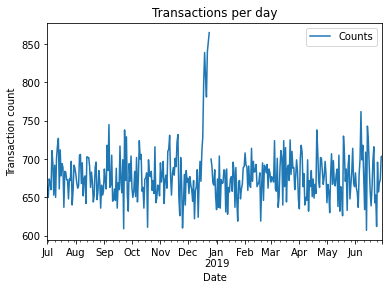

In [23]:
date_counts.plot()
plt.title('Transactions per day')
plt.xlabel('Date')
plt.ylabel('Transaction count')
plt.show()

We can see that sales rise up leading to Chrismas and the shops are closed on Chrismas day. Other than that we dont have any outliers. Let's move on to check the pack sizes in PR0D_SIZE and see if they are sensible.

In [24]:
#this step is to parse numbers and get rid of the letters or any other special characters
transactionData['PROD_SIZES']=transactionData['PROD_SIZES'].str.extract('(\d+)')
transactionData['PROD_SIZES']
transactionData['PROD_SIZES'].describe()
PROD_SIZES_COUNTS = transactionData["PROD_SIZES"].value_counts()
PROD_SIZES_COUNTS = pd.DataFrame(data=PROD_SIZES_COUNTS)
PROD_SIZES_COUNTS = PROD_SIZES_COUNTS.sort_index()

In [25]:
#changing the placement of the last two rows to be the first two rows
last_two_rows = PROD_SIZES_COUNTS.iloc[-2:]
PROD_SIZES_COUNTS = pd.concat([last_two_rows, PROD_SIZES_COUNTS.iloc[:-2]])

<BarContainer object of 20 artists>

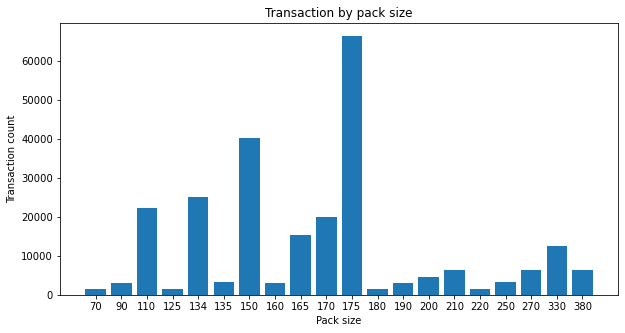

In [26]:
#plotting our figure
plt.figure(figsize=(10, 5))
plt.title('Transaction by pack size')
plt.xlabel('Pack size')
plt.ylabel('Transaction count')
plt.bar(PROD_SIZES_COUNTS.index, PROD_SIZES_COUNTS['PROD_SIZES'])

We can see the pack sizes bought seem to be reasonable. The most popular pack sizes are 175 g and 150 g. Too big and too small packs are both not that popular.

Let's look at the brands now. To analyse the brands we will use the PROD_BRAND column we have created before. As the brand names are usually in the beginning of the string, we will extract the first word of the string in every column.

In [27]:
transactionData['PROD_BRAND'] = transactionData['PROD_BRAND'].str.split().str[0]
transactionData['PROD_BRAND']

0          Natural
1              CCs
2           Smiths
3           Smiths
4           Kettle
            ...   
264831      Kettle
264832    Tostitos
264833     Doritos
264834     Doritos
264835    Tostitos
Name: PROD_BRAND, Length: 246740, dtype: object

Let's group these together now to see if there are any of the same brands with different names. Before we group them together we can see that some brands have multiple name enties(doritos, dorito). Let's remove all the s's at the end of the string so the value.counts() function can see they're the same brand. The use of uppercase and lowercase seems to follow the same convention in every string however just to be safe, we will convert everything to lowercase.

In [28]:
transactionData['PROD_BRAND'] = transactionData['PROD_BRAND'].str.replace('s$', '', regex=True)
transactionData['PROD_BRAND'] = transactionData['PROD_BRAND'].str.lower()


In [29]:
brand_counts = transactionData["PROD_BRAND"].value_counts()
brand_counts = pd.DataFrame(data=brand_counts)

When we look at the data we can see that we still have some brand entires twice. Let's find them all and combine them. red&rrd, ww& woolworth, infuzion&infzn,natural&ncc, grain& grnwve, snbt,sunbite.

In [30]:
#we can make all these changes in one line however for easier readibility I'll combine each brand on a different line.
brand_counts.rename(index={"red": "redrockdeli", "rrd": "redrockdeli"}, inplace=True)
brand_counts.rename(index={"ww": "woolworths", "woolworth": "woolworths"}, inplace=True)
brand_counts.rename(index={"infuzion": "infuzions", "infzn": "infuzions"}, inplace=True)
brand_counts.rename(index={"natural": "naturalchipco", "ncc": "naturalchipco"}, inplace=True)
brand_counts.rename(index={"grain": "grainwaves", "grnwve": "grainwaves"}, inplace=True)
brand_counts.rename(index={"snbt": "sunbites", "sunbite": "sunbites"}, inplace=True)
#now that we have the same naming convention let's merge the same brands into the same row.
brand_counts=brand_counts.groupby(brand_counts.index).sum()
brand_counts = brand_counts.sort_values('PROD_BRAND')

Let's create a plot to see how much each brand sold throughout the year.

<BarContainer object of 20 artists>

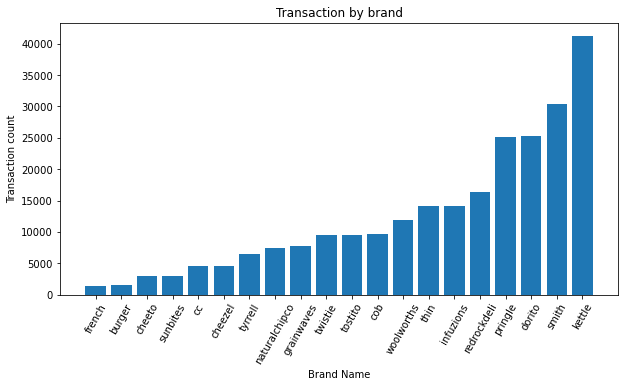

In [31]:
plt.figure(figsize=(10, 5))
plt.title('Transaction by brand')
plt.xlabel('Brand Name')
plt.xticks(rotation=60)
plt.ylabel('Transaction count')
plt.bar(brand_counts.index, brand_counts['PROD_BRAND'])

## Insights
There we go we can see the most popular brands now. We vab see that the most sold chip brand was kettle, followed by Smiths and Doritos. We can also see that the least popular chip brands are french fries, burger and Cheetos. Which is interesting to see as I personally thought Cheetos would sell more.

Okay! We've cleaned our transactionData dataset and analysed it. Let's do the same for our customer dataset(purchase behaviour).

In [32]:
purchaseBehvaiour

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream
...,...,...,...
72632,2370651,MIDAGE SINGLES/COUPLES,Mainstream
72633,2370701,YOUNG FAMILIES,Mainstream
72634,2370751,YOUNG FAMILIES,Premium
72635,2370961,OLDER FAMILIES,Budget


In [33]:
customer_lifestage_count=purchaseBehvaiour.groupby(['LIFESTAGE']).count()
customer_lifestage_count.drop('LYLTY_CARD_NBR', axis=1, inplace=True)
customer_lifestage_count =customer_lifestage_count.rename(columns={'PREMIUM_CUSTOMER': 'Customer_Count'})
customer_lifestage_count

,Customer_Count
LIFESTAGE,
MIDAGE SINGLES/COUPLES,7275
NEW FAMILIES,2549
OLDER FAMILIES,9780
OLDER SINGLES/COUPLES,14609
RETIREES,14805
YOUNG FAMILIES,9178
YOUNG SINGLES/COUPLES,14441


<BarContainer object of 7 artists>

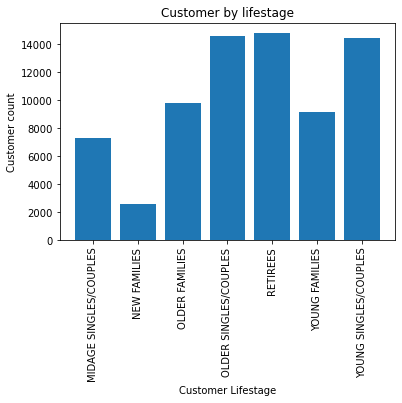

In [34]:
plt.figure(figsize=(6, 4))
plt.title('Customer by lifestage')
plt.xlabel('Customer Lifestage')
plt.xticks(rotation=90)
plt.ylabel('Customer count')
plt.bar(customer_lifestage_count.index, customer_lifestage_count['Customer_Count'])

We can see that most customers are retirees and older singles/couples. Followed by young singles/couples. 

Let's combine the two tables(transactionData,purchaseBehvaiour). We are primarily interested in purchases and which customer they're connected to so we'll do a left join. 

In [35]:
combined_df = pd.merge(transactionData, purchaseBehvaiour, on='LYLTY_CARD_NBR', how='left')


In [36]:
#check if there are any null values. There are no null values!
print(combined_df.isnull().values.any())

False


Let's save this dataset for later use in task 2

In [37]:
combined_df.to_csv('combined_df_for_task2.csv', index=True)
combined_df_fortask1=combined_df

In [38]:
#removing the columns we don't need
combined_df_for_last_bit=combined_df_fortask1.drop(['LYLTY_CARD_NBR', 'TXN_ID','PROD_NBR','PROD_SIZES','PROD_NAME','DATE','PROD_QTY','STORE_NBR'], axis=1)
combined_df_fortask1 = combined_df_fortask1.drop(['LYLTY_CARD_NBR', 'TXN_ID','PROD_NBR', 'PROD_NAME','PROD_SIZES','PROD_BRAND','DATE','PROD_QTY','STORE_NBR'], axis=1)

In [39]:
combined_df_fortask1

,TOT_SALES,LIFESTAGE,PREMIUM_CUSTOMER
0,6.0,YOUNG SINGLES/COUPLES,Premium
1,6.3,MIDAGE SINGLES/COUPLES,Budget
2,2.9,MIDAGE SINGLES/COUPLES,Budget
3,15.0,MIDAGE SINGLES/COUPLES,Budget
4,13.8,MIDAGE SINGLES/COUPLES,Budget
...,...,...,...
246735,10.8,YOUNG SINGLES/COUPLES,Premium
246736,4.4,YOUNG SINGLES/COUPLES,Premium
246737,8.8,YOUNG SINGLES/COUPLES,Premium
246738,7.8,YOUNG SINGLES/COUPLES,Premium


Let's create a dataset to find the total sales by lifestage and premium customer

In [40]:
sales_by_Cardtype = combined_df_fortask1.groupby('PREMIUM_CUSTOMER')[['TOT_SALES']].sum()

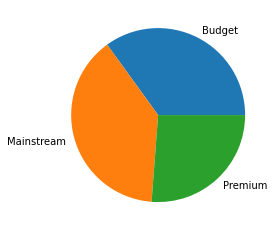

In [41]:
plt.pie(sales_by_Cardtype['TOT_SALES'], labels=sales_by_Cardtype.index)
# display the chart
plt.show()

We can see that most customers who have cards and made purchases were using a Budget or Mainstream membership.

Let's do the same for total sales by lifestage, to see which lifestage customers make more purchases.

In [42]:
sales_by_LifeStage = combined_df_fortask1.groupby('LIFESTAGE')[['TOT_SALES']].sum()
sales_by_LifeStage
#plt.bar(df_byLifeStage)

,TOT_SALES
LIFESTAGE,
MIDAGE SINGLES/COUPLES,172523.80
NEW FAMILIES,47347.95
OLDER FAMILIES,328519.90
OLDER SINGLES/COUPLES,376019.65
RETIREES,342381.90
YOUNG FAMILIES,294627.90
YOUNG SINGLES/COUPLES,243756.60


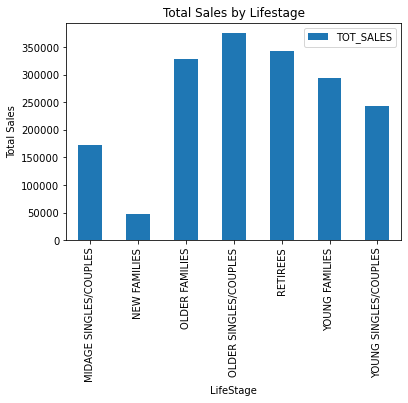

In [43]:
ax=sales_by_LifeStage.plot(kind='bar')
ax.set_xlabel('LifeStage')
ax.set_ylabel('Total Sales')
ax.set_title('Total Sales by Lifestage')
plt.show()


## Insights
We can see that older singles/couples, older families and retirees made more chips purchases than the other customer groups. Perhaps we can use this information to change the advertisement platforms and contents to increase interest in younger adults as well.

Let's see which Lifestage+ customer type the sales are coming from.

In [44]:
sales_by_LifeStage_and_CardType = combined_df_fortask1.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])[['TOT_SALES']].sum()

In [45]:
sales_by_LifeStage_and_CardType
sales_by_LifeStage_and_CardType = sales_by_LifeStage_and_CardType.unstack()
sales_by_LifeStage_and_CardType

TOT_SALES                      
PREMIUM_CUSTOMER           Budget Mainstream    Premium
LIFESTAGE                                              
MIDAGE SINGLES/COUPLES   33345.70   84734.25   54443.85
NEW FAMILIES             20607.45   15979.70   10760.80
OLDER FAMILIES          156863.75   96413.55   75242.60
OLDER SINGLES/COUPLES   127833.60  124648.50  123537.55
RETIREES                105916.30  145168.95   91296.65
YOUNG FAMILIES          129717.95   86338.25   78571.70
YOUNG SINGLES/COUPLES    57122.10  147582.20   39052.30

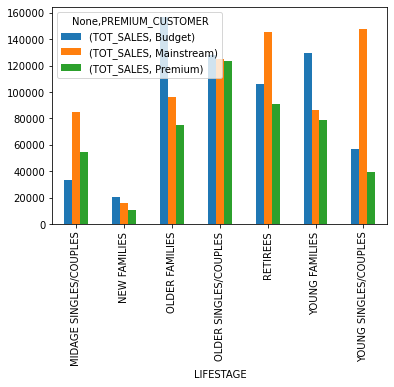

In [46]:
ax=sales_by_LifeStage_and_CardType.plot(kind='bar')
plt.show()


## Insights
We can get a lot of information from this barchart. None of the age groups have Premium as their most preffered card type. Maybe we should make Premium card more desirable by having more promotions and discounts exclusive to people who use the premium membership.
We can also see that most chip sales are coming from older budget families, singles/couples and retires and retirees and young singles/couples that have the mainstream membership.

We can now check if this difference in customer purchase quantities are due to there being more customers to buy chips.

In [47]:
peoplecount_bylifestage_bycardtype = combined_df_fortask1.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER']).count()
peoplecount_bylifestage_bycardtype=peoplecount_bylifestage_bycardtype.unstack()
peoplecount_bylifestage_bycardtype

TOT_SALES                   
PREMIUM_CUSTOMER          Budget Mainstream Premium
LIFESTAGE                                          
MIDAGE SINGLES/COUPLES      4691      11095    7612
NEW FAMILIES                2824       2185    1488
OLDER FAMILIES             21514      13241   10403
OLDER SINGLES/COUPLES      17172      17061   16560
RETIREES                   14225      19970   12236
YOUNG FAMILIES             17763      11947   10784
YOUNG SINGLES/COUPLES       8573      19544    5852

We have now created two dataframes, one containing information of sale quantities per customer lifestage and premium_customer type, the other one containing information about customer counts per customer lifestage and premium_customer type. Let's divide the sale quantity dataset by the customer counts dataset to see sale quantities per person in each category.


In [48]:
result = sales_by_LifeStage_and_CardType.div(peoplecount_bylifestage_bycardtype)
result

TOT_SALES                     
PREMIUM_CUSTOMER          Budget Mainstream   Premium
LIFESTAGE                                            
MIDAGE SINGLES/COUPLES  7.108442   7.637156  7.152371
NEW FAMILIES            7.297256   7.313364  7.231720
OLDER FAMILIES          7.291241   7.281440  7.232779
OLDER SINGLES/COUPLES   7.444305   7.306049  7.459997
RETIREES                7.445786   7.269352  7.461315
YOUNG FAMILIES          7.302705   7.226772  7.285951
YOUNG SINGLES/COUPLES   6.663023   7.551279  6.673325

## Insights
We can see that sales by each customer type is similar however mainstream midage singles/couples seem to be making more purchases per customer compared to budget young singles/couples. Let's see if this is a significant difference by performing a t-test.


In [49]:
#t-test on two values
midage_mainstream = combined_df_fortask1[(combined_df_fortask1['LIFESTAGE']=='MIDAGE SINGLES/COUPLES') & (combined_df_fortask1['PREMIUM_CUSTOMER']=='Mainstream')]['TOT_SALES']
young_budget = combined_df_fortask1[(combined_df_fortask1['LIFESTAGE']=='YOUNG SINGLES/COUPLES') & (combined_df_fortask1['PREMIUM_CUSTOMER']=='Budget')]['TOT_SALES']

In [50]:
t_stat, p_value = ttest_ind(midage_mainstream, young_budget, equal_var=False)


In [51]:
print('T_stat is:', t_stat )
print('P_value is:', p_value )

T_stat is: 26.66895079465475
P_value is: 1.2126956790291748e-153


## Insights
We can see that our p_value is smaller than 0.05 and we have a large value so these two groups are significantly different. Meaning young couple/singles using a budget membership and midage singles/couples using a mainstream membership buy significantly different quantities of chips per customer. Midage singles/couples with a mainstream membership buy significantly more packs of chips than young singles/couples with a budget membership.

From the results table we remember that mainstream midage singles/couples and mainstream young singles/couples have larger purchase power. Let's check if there are any brands that they specifically prefer.

In [54]:
combined_df_for_last_bit

,TOT_SALES,PROD_BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,6.0,natural,YOUNG SINGLES/COUPLES,Premium
1,6.3,cc,MIDAGE SINGLES/COUPLES,Budget
2,2.9,smith,MIDAGE SINGLES/COUPLES,Budget
3,15.0,smith,MIDAGE SINGLES/COUPLES,Budget
4,13.8,kettle,MIDAGE SINGLES/COUPLES,Budget
...,...,...,...,...
246735,10.8,kettle,YOUNG SINGLES/COUPLES,Premium
246736,4.4,tostito,YOUNG SINGLES/COUPLES,Premium
246737,8.8,dorito,YOUNG SINGLES/COUPLES,Premium
246738,7.8,dorito,YOUNG SINGLES/COUPLES,Premium


In [65]:
combined_df_for_last_bit = combined_df_for_last_bit.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER', 'PROD_BRAND'])['TOT_SALES'].sum()

LIFESTAGE              PREMIUM_CUSTOMER  PROD_BRAND
YOUNG FAMILIES         Premium           cob           3233.8
                                         dorito        9061.9
                                         french         384.0
                                         grain         1724.4
                                         grnwve         468.1
                                                        ...  
YOUNG SINGLES/COUPLES  Premium           tostito       1698.4
                                         twistie       1619.0
                                         tyrrell        991.2
                                         woolworth      163.8
                                         ww            1105.9
Name: TOT_SALES, Length: 100, dtype: float64

In [88]:
combined_df_for_last_bit=combined_df_for_last_bit.to_frame()
combined_df_for_last_bit = combined_df_for_last_bit.sort_index(level=[0, 1, 2])


In [98]:
YoungMainstream=combined_df_for_last_bit.loc[('YOUNG SINGLES/COUPLES', 'Mainstream')].sort_values('TOT_SALES', ascending=False)
YoungMainstream[:3]

,TOT_SALES
PROD_BRAND,
kettle,35423.6
dorito,20925.9
pringle,16006.2


In [97]:
MidageMainstream=combined_df_for_last_bit.loc[('MIDAGE SINGLES/COUPLES', 'Mainstream')].sort_values('TOT_SALES', ascending=False)
MidageMainstream[:3]

,TOT_SALES
PROD_BRAND,
kettle,20231.80
dorito,10714.65
smith,9874.10


## Insights
We can see that for both groups the most popular brands are Kettle and Dorito's chips. Following those two Midage singles/couples prefer Smiths chips whereas Young singles/couples prefer Pringles.